In [5]:
import fitsio,os,sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pylab as py


In [6]:
### selecting quasars in DR16Q catalog 
dr16cat='/uufs/chpc.utah.edu/common/home/sdss/dr16/sdss/spectro/redux/v5_13_0/spAll-v5_13_0.fits'

dr16 = fits.open(dr16cat)
dh = dr16[1].header
d = dr16[1].data

#p.unique(d['OBJTYPE']) #chararray(['GALAXY', 'NA', 'QSO', 'SKY', 'SPECTROPHOTO_STD'], dtype='<U16')

qso = (d['CLASS']=='QSO') & (d['ZWARNING'] == 0)
print('Number of quasars in dr16',np.sum(qso))
print(np.unique(d['CLASS']))
from astropy.table import Table
dr16Q = d[qso]
t=Table(dr16Q)

path = '/uufs/chpc.utah.edu/common/home/astro/dawson/sarahE/KDE_eBOSS_pairmatch/'

os.system('rm '+path+'dr16Q_from_spAllv5_13_0.fits')
t.write(path+'dr16Q_from_spAllv5_13_0.fits')

Number of quasars in dr16 830740
['GALAXY' 'QSO' 'STAR']


In [293]:
dh

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                 4016 /Number of bytes per row                         
NAXIS2  =              3946000 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                  236 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [8]:
len(d),len(t),np.min(t['Z']),np.max(t['Z'])

(3946000, 830740, 0.00046062307, 7.0423255)

In [9]:
path = '/uufs/chpc.utah.edu/common/home/astro/dawson/sarahE/KDE_eBOSS_pairmatch/'

pairs = 'KDEpairs_nbckde_dr6_uvxORlowz_35078_2.9-62arscsec.fits'


a,h = fitsio.read(path+pairs,header=True) ### 35078 pair candidates 2.9"< separation < 62"
print(h)


XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11
BITPIX  =                    8 /Required value
NAXIS   =                    2 /Required value
NAXIS1  =                  216 /Number of bytes per row
NAXIS2  =                35078 /Number of rows
PCOUNT  =                    0 /Normally 0 (no varying arrays)
GCOUNT  =                    1 /Required value
TFIELDS =                   27 /Number of columns in table
COMMENT
COMMENT  *** End of mandatory fields ***
COMMENT
COMMENT
COMMENT  *** Column names ***
COMMENT
TTYPE1  = 'SEP     '           /
TTYPE2  = 'RA1     '           /
TTYPE3  = 'DEC1    '           /
TTYPE4  = 'OBJID1  '           /
TTYPE5  = 'QSOTS1  '           /
TTYPE6  = 'LOWZTS1 '           /
TTYPE7  = 'MIDZTS1 '           /
TTYPE8  = 'HIGHZTS1'           /
TTYPE9  = 'UVXTS1  '           /
TTYPE10 = 'QSOPROB1'           /
TTYPE11 = 'STARPROB1'          /
TTYPE12 = 'GMAG1   '           /
TTYPE13 = 'IMAG1   '           /
TTYPE14 = 'EBMV1   '           

In [10]:
### we found 12,197 "QSO-nonQSO" pairs from DR16Q and now I try to
### break the population into QSO-STAR, QSO-GALAXY,

from astrometry.util.starutil_numpy import * 
from astrometry.libkd import spherematch

radius_in_deg = 2.9/3600.

### without limiting 
(m1_hg,m2_hg,distance1_hg) = spherematch.match_radec(a['RA1'], a['DEC1'], d['RA'], d['DEC'], radius_in_deg,notself=True,nearest=True)

(m12_hg,m22_hg,distance2_hg) = spherematch.match_radec(a['RA2'], a['DEC2'], d['RA'], d['DEC'], radius_in_deg,notself=True,nearest=True)

print(len(m1_hg),len(m12_hg))

q_star_ind = []
q_star_z = []

q_gal_ind = []
q_gal_z = []

q_NA_ind = []
q_NA_zind = []
q_NA_flag = []

qq_ind = []
qq_zind = []

for p in range(len(a)):
    
    if (p in m1_hg) & (p in m12_hg):
 
        w1 = np.where(m1_hg == p)[0]
        w12 = np.where(m12_hg == p)[0]
        
        if ((d['OBJTYPE'][m2_hg[w1]] == 'QSO') & (d['OBJTYPE'][m22_hg[w12]] == 'NA')):
                        
            q_NA_ind.append(m1_hg[w1][0])
            q_NA_zind.append(m2_hg[w1][0])
            q_NA_flag.append(m22_hg[w12][0])

        elif ((d['OBJTYPE'][m2_hg[w1]] == 'NA') & (d['OBJTYPE'][m22_hg[w12]] == 'QSO')):
            
            q_NA_ind.append(m12_hg[w12][0])
            q_NA_zind.append(m22_hg[w12][0])
            q_NA_flag.append(m2_hg[w1][0])
        
print(len(q_NA_ind),len(q_NA_zind))

9743 9531
1116 1116


In [11]:
### sanity check:  all of this array has to be NA
np.unique(d['OBJTYPE'][q_NA_flag])

chararray(['NA'], dtype='<U16')

In [12]:
np.min(d['Z'][q_NA_zind]), np.max(d['Z'][q_NA_zind])

(-0.003332294, 6.6379523)

In [13]:
### match this with DR16Q catalog
from astrometry.util.starutil_numpy import * 
from astrometry.libkd import spherematch

t,h = fitsio.read(path+'dr16Q_from_spAllv5_13_0.fits',header=True)

print(np.unique(t['OBJTYPE']))
ra = t['RA']
dec = t['DEC']

radius_in_deg = 2.9/3600.
(m1,m2,distance) = spherematch.match_radec(a['RA1'], a['DEC1'], ra, dec, radius_in_deg,notself=True,nearest=True)
print(len(m1))

## For the second member of the pairs
(m12,m22,distance2) = spherematch.match_radec(a['RA2'],a['DEC2'], ra, dec, radius_in_deg,notself=True,nearest=True)
print(len(m12))
#print(h)

[b'GALAXY' b'NA' b'QSO' b'SPECTROPHOTO_STD']
8832
8626


In [14]:
catch  = 0
halfgood_catch = 0 
good_catch = 0
same_catch = 0

halfgood_ind = []
goodind1 = []
goodind2 = []
halfgoodzind = []
zind1 = []
zind2 = []

for p in range(len(a)):
    
    if (p in m1) | (p in m12):
        
        w1 = np.where(m1 == p)[0]
        w12 = np.where(m12 == p)[0]

        halfgood_catch += 1
        
        if len(w1)>0:
            
            halfgood_ind.append(m1[w1][0])
            halfgoodzind.append(m2[w1][0])
            
        elif len(w12) > 0:
            
            halfgood_ind.append(m12[w12][0])
            halfgoodzind.append(m22[w12][0])
            

    if (p in m1) & (p in m12):
        
        w1 = np.where(m1 == p)[0]
        w2 = np.where(m12 == p)[0]
        #print(p, w1,w2,len(w1),len(w2))
        catch += 1
        
        if (len(w1) >0) & (len(w2) >0):
            
            if (w1[0] == w2[0]):
                same_catch +=1
#                 if m1[w2] not in halfgood_ind:
#                     halfgood_ind += m1[w1]
#                     halfgoodz.append(m2[w1])
            else:
                good_catch +=1
                goodind1.append(m1[w1][0]) 
                goodind2.append(m12[w2][0]) 
                zind1.append(m2[w1][0])
                zind2.append(m22[w2][0])
            
            
print('catch:',catch)
print('halfgood_catch:',halfgood_catch)
print('good_catch:',good_catch)
print('same_catch:',same_catch)
print('sanity check:',len(zind1),len(zind2))            

catch: 3275
halfgood_catch: 14183
good_catch: 3253
same_catch: 22
sanity check: 3253 3253


In [15]:
### Sanity check: a['SEP'][goodind1[i]] and a['SEP'][goodind2[i]] has to be indentical
i=0
print(a['RA1'][goodind1[i]],a['DEC1'][goodind1[i]],a['RA2'][goodind2[i]],\
      a['DEC2'][goodind2[i]],t['Z'][zind1[i]],t['Z'][zind2[i]], a['SEP'][goodind1[i]],a['SEP'][goodind2[i]])



194.92320251464844 33.952674865722656 194.92276000976562 33.953453063964844 1.4015414 1.7568667 3.097511697051448 3.097511697051448


In [ ]:
#### WRITE OUT a table of pairs and thei i, g mags, redshift, EBOSS_TARGET_ID, MODELFLUX, MODELMAG, 

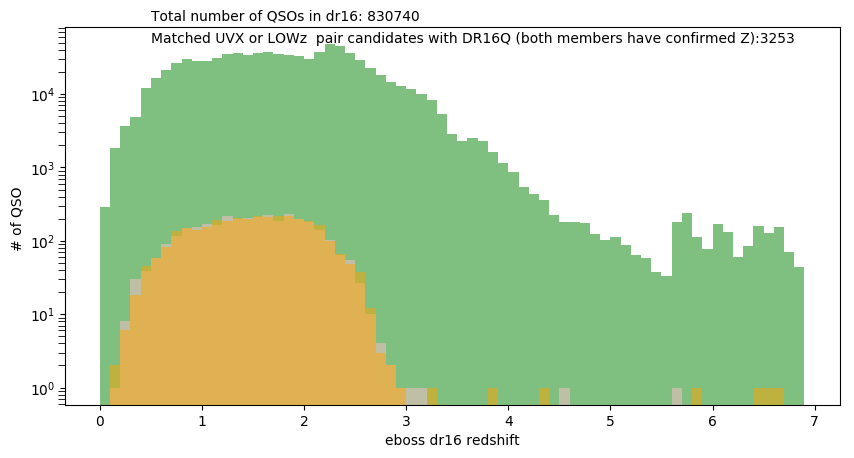

In [16]:
fig = plt.figure(figsize=(10, 5), dpi=100)

plt.hist(t['Z'], bins= np.arange(0,7,0.1),alpha=0.5,color='green')  # `density=False` would make counts
plt.hist(t['Z'][zind2], bins= np.arange(0,7,0.1),alpha=0.5,color='pink')  # `density=False` would make counts
plt.hist(t['Z'][zind1], bins= np.arange(0,7,0.1),alpha=0.5,color='orange')  # `density=False` would make counts

plt.xlabel('eboss dr16 redshift')
plt.ylabel('# of QSO ')
plt.yscale('log')
plt.tick_params(which='minor', length=5)
plt.text(0.5,1e5,'Total number of QSOs in dr16: '+str(len(t)))
plt.text(0.5,0.5e5,'Matched UVX or LOWz  pair candidates with DR16Q (both members have confirmed Z):'+str(good_catch))
plt.savefig(path+'z_dist_pairs_dr16.png')


In [18]:
from astropy.cosmology import FlatLambdaCDM
from math import sqrt, pi

### theta x da(z) = Rp  ---> 2.9/3600. x dc/(1+z) = Rp 
z = np.arange(0.01,7,0.1)
cosmo = FlatLambdaCDM(H0=100, Om0=0.307, Tcmb0=2.725)
zdc = cosmo.comoving_distance(z).value

Rpmin = 2.9*(np.pi/180)*(1/3.6)*zdc/(1+z)  #in kpc/h
Rpmax = 62*(np.pi/180)*(1/3.6)*zdc/(1+z)


#### calculate Rp for the pairs Rp= angsep*dc/(1+z)
#### find actual pairs with |v|< 2000 km/s
z1 = t['Z'][zind1]
z2 = t['Z'][zind2]

v = 3e5 * (z1-z2)/(1+z1)

pairs = (abs(v) < 2000)

zpair1 = z1[pairs]
zpair2 = z2[pairs]


print(np.min(zpair1),np.max(zpair1),np.sum(pairs))

dc_pair = cosmo.comoving_distance(zpair1).value
angsep = a['SEP'][goodind1][pairs] # shouldn't matter to use a['SEP'][goodind2]; identical
Rp_pair = angsep*(np.pi/180)*(1/3.6)* dc_pair/(1+zpair1)


### calculate Rp for pairs with one member to have found a redshift in DR16 andthe other member is anything else
halfgoodz = t['Z'][halfgoodzind]
dc_hg = cosmo.comoving_distance(halfgoodz).value

angsep_hg = a['SEP'][halfgood_ind] 
Rp_hg = np.asarray(angsep_hg)*(np.pi/180)*(1/3.6)* dc_hg/(1+np.asarray(halfgoodz))


### calculate Rp for pairs with one member to have found a redshift in DR16 andthe other member is UNKNOWN [NA]
q_NA_z = d['Z'][q_NA_zind]
dc_qNA = cosmo.comoving_distance(q_NA_z).value

angsep_qNA = a['SEP'][q_NA_ind] 
Rp_qNA = np.asarray(angsep_qNA)*(np.pi/180)*(1/3.6)* dc_qNA/(1+np.asarray(q_NA_z))


##### Writing out the table of True quasar pairs with |v| < 2000 km/s

# t = Table()
# cc = Column(Rp_pair, name='Rp')
# t.add_column(cc,index=0)
# cc = Column(angsep, name='Sep_arcsec')
# t.add_column(cc,index=0)
# cc = Column(zpair1, name='Z1')
# t.add_column(cc,index=0)
# cc = Column(zpair2, name='Z2')
# t.add_column(cc,index=0)
# cc = Column(a['RA1'][goodind1][pairs], name='RA1')
# t.add_column(cc,index=0)
# cc = Column(a['DEC1'][goodind1][pairs], name='DEC1')
# t.add_column(cc,index=0)
# cc = Column(, name='EBOSS_TARGET_ID1') 
# t.add_column(cc,index=0)
# cc = Column(, name='i_MODELMAG1') 
# t.add_column(cc,index=0)

# t.add_column(cc,index=0)
# cc = Column(a['RA2'][goodind2][pairs], name='RA2')
# t.add_column(cc,index=0)
# cc = Column(a['DEC2'][goodind2][pairs], name='DEC2')
# t.add_column(cc,index=0)
# cc = Column(, name='EBOSS_TARGET_ID2') 
# t.add_column(cc,index=0)
# cc = Column(, name='i_MODELMAG2') 
# t.add_column(cc,index=0)
# cc = Column(abs(v[pairs]), name='velocity') # km/s
# t.add_column(cc,index=0)

# t.write(path+'eboss_true_QSObinaries.fits')




0.5619411 2.3529246 222


In [19]:
len(zpair1),len(dc_pair),len(Rp_pair),len(angsep),len(halfgoodz), np.min(zpair1), np.sum((zpair1<0.8) |(zpair1 >2.2))

(222, 222, 222, 222, 14183, 0.5619411, 14)

In [20]:
print('Angular separation: ','\t',np.min(angsep),np.max(angsep))

print('Rp_hg: ','\t',np.min(Rp_hg),np.max(Rp_hg))
print('angsep_hg: ','\t',np.min(angsep_hg),np.max(angsep_hg))
print('halfgoodz range:','\t',np.min(halfgoodz),np.max(halfgoodz))

Angular separation:  	 3.8030237293779474 61.94016486996114
Rp_hg:  	 13.687838036835927 365.31338439435007
angsep_hg:  	 2.943077246891923 61.99935709673634
halfgoodz range: 	 0.14096048 6.6446624


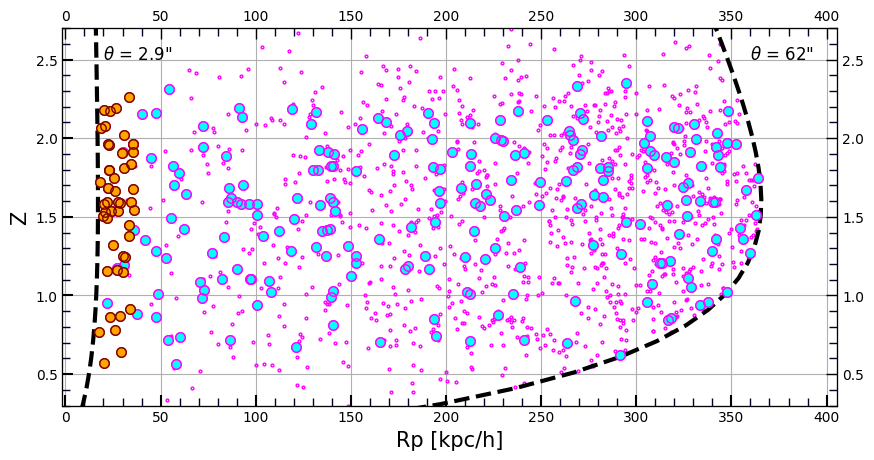

open pink circles are pairs with one member having had a redshift in DR16Q:  14183
filled orange circles are the 47 pairs with both members to have found a redshift in 
filled cyan circles are {} pairs that both their members have found a redshift in DR16


In [21]:
fig = plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(111)



Rp_47pairs = [34.6,36.1,26.1,35.3,26.5,35.6,35.3,25.6,22.9,26.1,23.4,
                         26.9,18.7,23.1,33.5,34.6,20.6,20.3,22.3,27.8,18.20,22.7,
                         27.5,20.5,24.8,31.3,34.0,33.6,19.5,30.4,22.0,20.2,
                         33.2,29.9,23.2,31.0,30.5,24.1,21.9,29.2,28.7,30.8,
                         17.7,28.8,22.6,20.8,21.8]

z_47_pairs = [1.838,1.545,0.778,1.961,2.195,1.911,1.677,1.744,1.956,
 1.666,2.173,1.164,2.062,1.795,1.445,1.596,1.529,2.180,
 1.686,1.597,1.721,1.799,1.534,0.573,1.324,1.245,0.912,
 2.261,1.506,1.151,1.153,1.584,1.376,1.905,0.863,1.809,
 1.249,1.535,1.494,0.641,0.870,2.018,0.770,1.587,1.961,2.080,1.597]




ofs=2
xlim = (np.min(Rpmin)-ofs,np.max(Rpmax)+40 )
ylim = (0.3,2.7)#(np.min(sq['DEC'])-ofs,np.max(sq['DEC'])+ofs )

#### the 12197 QSO-nonQSO
#py.plot(Rp_hg,np.asarray(halfgoodz),markersize = 2,marker='o',linestyle='',mfc='none',color='magenta')


#### the 1116
py.plot(Rp_qNA,np.asarray(q_NA_z),markersize = 2,marker='o',linestyle='',mfc='none',color='magenta')


py.plot(Rpmin,z,linestyle='--',color='black',linewidth = 3)
py.plot(Rpmax,z,linestyle='--',color='black',linewidth = 3)

py.plot(Rp_pair,zpair1,markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')
py.plot(Rp_pair,zpair1,markersize = 6,marker='o',linestyle='',color='cyan')
py.plot(Rp_pair,zpair1,markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')

py.plot(Rp_47pairs,z_47_pairs,markersize = 6.8,marker='o',linestyle='',mfc='none',color='maroon')
py.plot(Rp_47pairs,z_47_pairs,markersize = 6,marker='o',linestyle='',color='orange')
py.plot(Rp_47pairs,z_47_pairs,markersize = 6.8,marker='o',linestyle='',mfc='none',color='maroon')


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel('Rp [kpc/h]',fontsize=15)
ax.set_ylabel('Z',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
ax.grid()

output_filename = 'Rp_z_eboss_kde_dr16_match.png'
plt.savefig(path+output_filename)

plt.show()


print('open pink circles are pairs with one member having had a redshift in DR16Q:  '+str(halfgood_catch))
print('filled orange circles are the 47 pairs with both members to have found a redshift in ')
print('filled cyan circles are {} pairs that both their members have found a redshift in DR16')

In [301]:
Rp_pair[0],zpair1[0]

(21.59972419774752, 0.9543287)

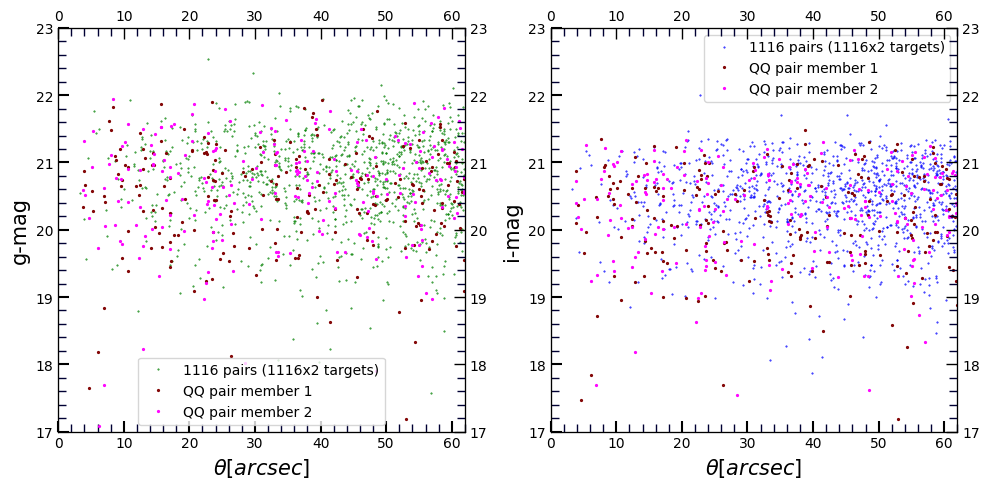

In [23]:
### magnitude distribution of confirmed pairs and the 

### 1116  QSO-NA pairs: two members, two sets of i-mags 2232 mags

###NOTE d  is the full spAll table
qimag_1116 = d['MODELMAG'][q_NA_zind][:,3]
NAimag_1116 = d['MODELMAG'][q_NA_flag][:,3] 

qgmag_1116 = d['MODELMAG'][q_NA_zind][:,1] 
NAgmag_1116 = d['MODELMAG'][q_NA_flag][:1] 


###NOTE  t is te DR16Q catalog ; for 115 binary quasars 
q1imag = t['MODELMAG'][zind1][pairs][:,3]
q2imag = t['MODELMAG'][zind2][pairs][:,3]


q1gmag = t['MODELMAG'][zind1][pairs][:,1]
q2gmag = t['MODELMAG'][zind2][pairs][:,1]


angsep_qNA = a['SEP'][q_NA_ind]    # angular separation for 1116 QSO-NA pairs
angsep_qq = a['SEP'][goodind1][pairs]  # angular separation in arcsec for 115 QSO-QSO pairs


fig = plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(121)

plt.plot(angsep_qNA, qgmag_1116,marker='.',markersize=.9,color='green',linestyle='')
plt.plot(angsep_qq, q1gmag,marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')
plt.plot(angsep_qq, q2gmag,marker='o',markersize=1.3,color='magenta',linestyle='',mfc='none')



xlim = [0,62]
ylim = [17,23]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel('g-mag',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')
ax.legend(['1116 pairs (1116x2 targets)','QQ pair member 1','QQ pair member 2'])



ax= fig.add_subplot(122)
plt.plot(angsep_qNA, qimag_1116,marker='.',markersize=.9,color='blue',linestyle='')
plt.plot(angsep_qq, q1imag,marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')
plt.plot(angsep_qq, q2imag,marker='o',markersize=1.3,color='magenta',linestyle='',mfc='none')


xlim = [0,62]
ylim = [17,23]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel('i-mag',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')

ax.legend(['1116 pairs (1116x2 targets)','QQ pair member 1','QQ pair member 2'])

fig.tight_layout() 



output_filename = 'gmag-imag_1116qNA_115qq.png'
plt.savefig(path+output_filename)


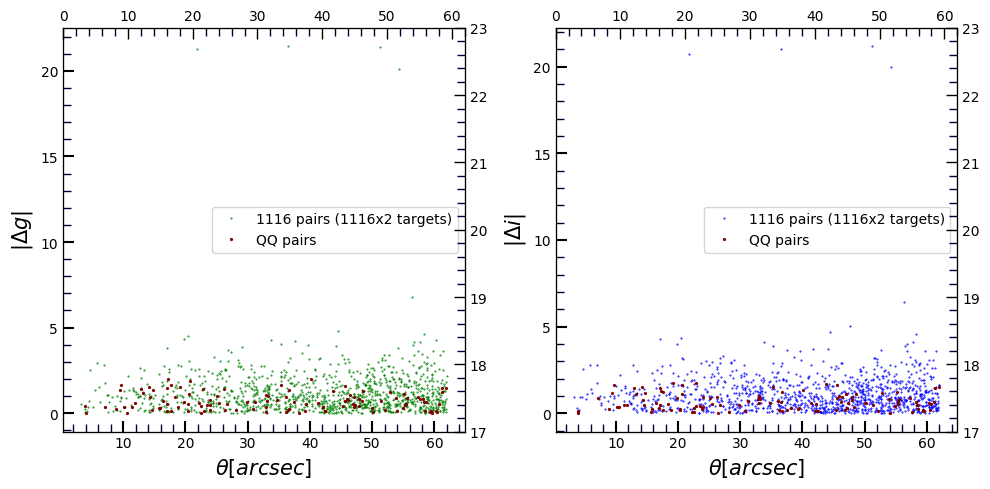

In [290]:
### magnitude distribution of confirmed pairs and the 

### 1116  QSO-NA pairs: two members, two sets of i-mags 2232 mags

###NOTE d  is the full spAll table
qimag_1116 = d['MODELMAG'][q_NA_zind][:,3]
NAimag_1116 = d['MODELMAG'][q_NA_flag][:,3] 

qgmag_1116 = d['MODELMAG'][q_NA_zind][:,1] 
NAgmag_1116 = d['MODELMAG'][q_NA_flag][:,1] 


###NOTE  t is te DR16Q catalog ; for 115 binary quasars 
q1imag = t['MODELMAG'][zind1][pairs][:,3]
q2imag = t['MODELMAG'][zind2][pairs][:,3]


q1gmag = t['MODELMAG'][zind1][pairs][:,1]
q2gmag = t['MODELMAG'][zind2][pairs][:,1]


angsep_qNA = a['SEP'][q_NA_ind]    # angular separation for 1116 QSO-NA pairs
angsep_qq = a['SEP'][goodind1][pairs]  # angular separation in arcsec for 115 QSO-QSO pairs


fig = plt.figure(figsize=(10, 5), dpi=100)
ax= fig.add_subplot(121)

plt.plot(angsep_qNA, abs(qgmag_1116-NAgmag_1116),marker='.',markersize=.9,color='green',linestyle='')
plt.plot(angsep_qq, abs(q1gmag-q2gmag),marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')



# xlim = [0,62]
# ylim = [17,23]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel(r'$|\Delta g|$',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')
ax.legend(['1116 pairs (1116x2 targets)','QQ pairs'])



ax= fig.add_subplot(122)
plt.plot(angsep_qNA, abs(qimag_1116-NAimag_1116),marker='.',markersize=.9,color='blue',linestyle='')
plt.plot(angsep_qq, abs(q1imag-q2imag),marker='o',markersize=1.3,color='maroon',linestyle='',mfc='none')
#plt.plot(angsep_qq, q2imag,marker='o',markersize=1.3,color='magenta',linestyle='',mfc='none')


#xlim = [0,62]
#ylim = [17,23]
#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

# ax.text(360,2.5,r'$\theta $'+' = 62"',fontsize=12)
# ax.text(20,2.5,r'$\theta $'+' = 2.9"',fontsize=12)

#ax.set_title(plot_title)
ax.set_xlabel(r'$\theta [arcsec]$',fontsize=15)
ax.set_ylabel('$|\Delta i|$',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')

ax.legend(['1116 pairs (1116x2 targets)','QQ pairs'])

fig.tight_layout() 



output_filename = 'delta_igmag_1116qNA_115qq.png'
plt.savefig(path+output_filename)


In [272]:
len(angsep_qq), len(q1gmag[pairs])

(115, 115)

Text(0, 1500, 'Total number of  matched UVX or LOWz  pair candidates with DR16Q : 7673')

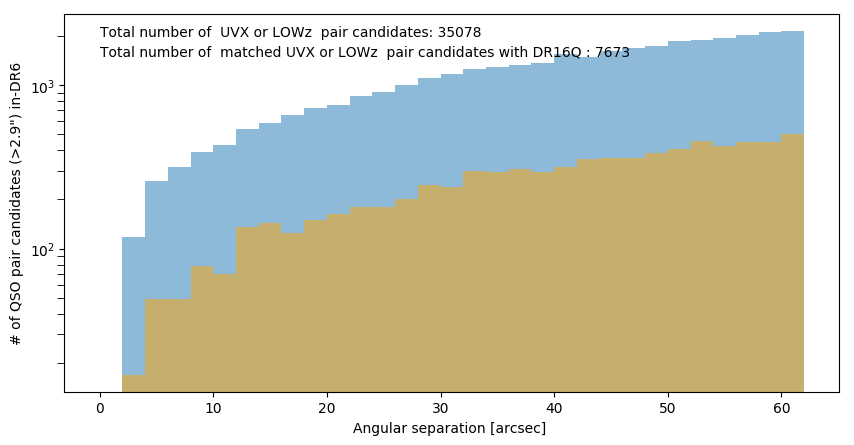

In [42]:
fig = plt.figure(figsize=(10, 5), dpi=100)

plt.hist(a['SEP'], bins= np.arange(0,64,2),alpha=0.5)  # `density=False` would make counts
plt.hist(matched_kde_eboss_pairs['SEP'], bins= np.arange(0,64,2),alpha=0.5,color='orange')  # `density=False` would make counts

plt.xlabel('Angular separation [arcsec] ')
plt.ylabel('# of QSO pair candidates (>2.9") in-DR6')
plt.yscale('log')
plt.tick_params(which='minor', length=5)
plt.text(0,2000,'Total number of  UVX or LOWz  pair candidates: '+str(len(a)))
plt.text(0,1500,'Total number of  matched UVX or LOWz  pair candidates with DR16Q : '+str(len(matched_kde_eboss_pairs)))

In [15]:
np.min(a['SEP']), len(a)

(2.9066882190782493, 35078)

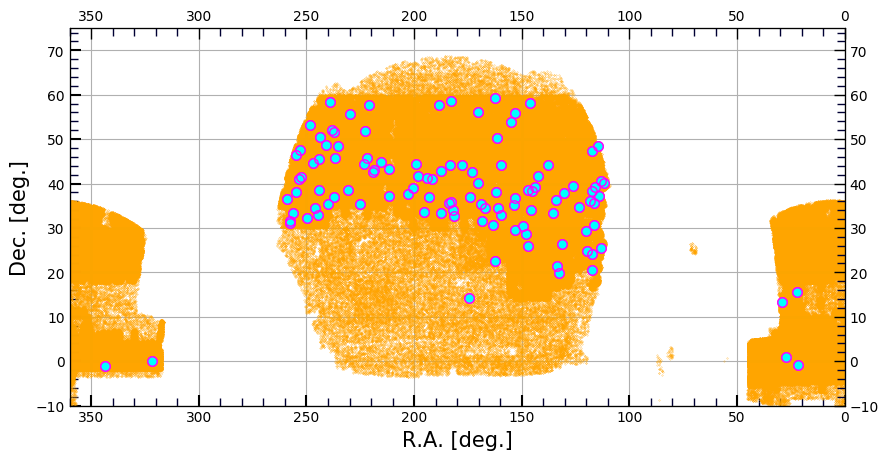

In [299]:
fig = py.figure(figsize=(10, 5), dpi=100)
output_filename='115_ebosspairs.png'
ax= fig.add_subplot(111)

ofs=2
xlim = (360,0)#(np.min(sq['RA'])-ofs,np.max(sq['RA'])+ofs )
ylim = (-10,75)#(np.min(sq['DEC'])-ofs,np.max(sq['DEC'])+ofs )

ii = (d['Z'] > 0.8 ) & (d['Z'] <2.34) & (d['ZWARNING']==0)
py.plot(d['RA'][ii],d['DEC'][ii],marker='.',markersize=0.4,linestyle='',color='orange')

py.plot(a['RA1'][goodind1][pairs],a['DEC1'][goodind1][pairs],markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')
py.plot(a['RA1'][goodind1][pairs],a['DEC1'][goodind1][pairs],markersize = 6,marker='o',linestyle='',color='cyan')
py.plot(a['RA1'][goodind1][pairs],a['DEC1'][goodind1][pairs],markersize = 6.8,marker='o',linestyle='',mfc='none',color='magenta')


ax.set_xlim(xlim)
ax.set_ylim(ylim)

#ax.set_title(plot_title)
ax.set_xlabel('R.A. [deg.]',fontsize=15)
ax.set_ylabel('Dec. [deg.]',fontsize=15)
ax.minorticks_on()
ax.tick_params(which='major', length=8, width=1.5, direction='in') 
ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')        

x_ax = ax.twiny()
x_ax.minorticks_on()
x_ax.tick_params(which='major', length=8, width=1.0, direction='in')
x_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in')     
x_ax.tick_params()
y_ax= plt.twinx()
y_ax.minorticks_on()
x_ax.set_xlim(xlim)
y_ax.set_ylim(ylim)
y_ax.tick_params(which='major', length=8, width=1.0, direction='in')
y_ax.tick_params(which='minor', length=6, color='#000033', width=1.0, direction='in') 
#ax.legend(['Green: QSO_NGC_v7_2: '+str(len(d)),' Blue: QSOs_NGC_v7_1: '+str(len(old))])
py.savefig(path+output_filename)
ax.grid()
plt.show()


In [249]:
len(a['RA1'][goodind1])

2128